In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score
from deap import creator, base, tools, algorithms
from scoop import futures
from sklearn import linear_model, datasets
import random
import numpy as np
from scipy import interpolate
from sklearn.linear_model import LogisticRegression
# import matplotlib.pyplot as plt

In [2]:
# Read in data from CSV
dfData = pd.read_csv('../data/Wednesday-workingHours-withoutInfinity-Sampled.pcap_ISCX.csv')

print(dfData.groupby(' Label').size())

 Label
0    5000
1    5500
2    5500
3    5499
4    5796
dtype: int64


In [3]:
# change dfData column order
column = list(dfData.columns.values)
column.remove(' Destination IP')
column.remove(' Timestamp')
column.insert(2, ' Destination IP')
column.insert(3, ' Timestamp')

dfData = dfData[column]

In [4]:
# Encode the classification labels to numbers
# Get classes and one hot encoded feature vectors
le = LabelEncoder()
le.fit(dfData[' Label'])
allClasses = le.transform(dfData[' Label'])
allFeatures_full = dfData.drop([' Label'], axis=1)

# omit the first 4 features
allFeatures = allFeatures_full.iloc[:,4:]

In [5]:
# normalize
from sklearn.preprocessing import normalize

allFeatures = pd.DataFrame(normalize(allFeatures, axis=1, copy=True, return_norm=False), columns=column[4:-1])

In [6]:
# Form training, test, and validation sets
X_trainAndTest, X_validation, y_trainAndTest, y_validation = train_test_split(allFeatures, allClasses, test_size=0.20, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_trainAndTest, y_trainAndTest, test_size=0.20, random_state=42)

In [7]:
# import numpy as np
np.shape(allFeatures)

(27295, 80)

In [8]:
# Feature subset fitness function
def getFitness(individual, X_train, X_test, y_train, y_test):

	# Parse our feature columns that we don't use
	# Apply one hot encoding to the features
	cols = [index for index in range(len(individual)) if individual[index] == 0]
# 	print(type(cols),np.shape(cols))
	X_trainParsed = X_train.drop(X_train.columns[cols], axis=1)
	X_trainOhFeatures = pd.get_dummies(X_trainParsed)
# 	print(X_trainOhFeatures)
	X_testParsed = X_test.drop(X_test.columns[cols], axis=1)
	X_testOhFeatures = pd.get_dummies(X_testParsed)
    
    # Remove any columns that aren't in both the training and test sets
	sharedFeatures = set(X_trainOhFeatures.columns) & set(X_testOhFeatures.columns)
	removeFromTrain = set(X_trainOhFeatures.columns) - sharedFeatures
	removeFromTest = set(X_testOhFeatures.columns) - sharedFeatures
	X_trainOhFeatures = X_trainOhFeatures.drop(list(removeFromTrain), axis=1)
	X_testOhFeatures = X_testOhFeatures.drop(list(removeFromTest), axis=1)
    
# 	print(np.shape(X_trainOhFeatures), np.shape(X_testOhFeatures))

	# Apply logistic regression on the data, and calculate accuracy
	clf = LogisticRegression()
# 	clf = svm.SVC()
	clf.fit(X_trainOhFeatures, y_train)
	predictions = clf.predict(X_testOhFeatures)
	accuracy = accuracy_score(y_test, predictions)

	# Return calculated accuracy as fitness
	return (accuracy,)


In [9]:
#========DEAP GLOBAL VARIABLES (viewable by SCOOP)========

# Create Individual
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# Create Toolbox
toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, len(allFeatures.columns) - 1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Continue filling toolbox...
toolbox.register("evaluate", getFitness, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)


In [10]:
def getHof():

	# Initialize variables to use eaSimple
	numPop = 200
	numGen = 30
	pop = toolbox.population(n=numPop)
	hof = tools.HallOfFame(numPop * numGen)
	stats = tools.Statistics(lambda ind: ind.fitness.values)
	stats.register("avg", np.mean)
	stats.register("std", np.std)
	stats.register("min", np.min)
	stats.register("max", np.max)

	# Launch genetic algorithm
	pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=numGen, stats=stats, halloffame=hof, verbose=True)

	# Return the hall of fame
	return hof


In [11]:
def getMetrics(hof):

	# Get list of percentiles in the hall of fame
	percentileList = [i / (len(hof) - 1) for i in range(len(hof))]
	
	# Gather fitness data from each percentile
	testAccuracyList = []
	validationAccuracyList = []
	individualList = []
	for individual in hof:
		testAccuracy = individual.fitness.values
		validationAccuracy = getFitness(individual, X_trainAndTest, X_validation, y_trainAndTest, y_validation)
		testAccuracyList.append(testAccuracy[0])
		validationAccuracyList.append(validationAccuracy[0])
		individualList.append(individual)
	testAccuracyList.reverse()
	validationAccuracyList.reverse()
	return testAccuracyList, validationAccuracyList, individualList, percentileList


In [12]:
# X_train = X_train[:6400]
# X_test = X_test[:1600]
# y_train = y_train[:6400]
# y_test = y_test[:1600]
# X_trainAndTest = X_trainAndTest[:8000]
# X_validation = X_validation[:2000]
# y_trainAndTest = y_trainAndTest[:8000]
# y_validation = y_validation[:2000]

In [13]:
np.shape(X_test)

(4368, 80)

In [14]:
'''
	First, we will apply logistic regression using all the features to acquire a baseline accuracy.
'''

individual = [1 for i in range(len(allFeatures.columns))]
testAccuracy = getFitness(individual, X_train, X_test, y_train, y_test)
validationAccuracy = getFitness(individual, X_trainAndTest, X_validation, y_trainAndTest, y_validation)
print('\nTest accuracy with all features: \t' + str(testAccuracy[0]))
print('Validation accuracy with all features: \t' + str(validationAccuracy[0]) + '\n')


Test accuracy with all features: 	0.8802655677655677
Validation accuracy with all features: 	0.8703059168345851



In [15]:
# cols

In [16]:
'''
	Now, we will apply a genetic algorithm to choose a subset of features that gives a better accuracy than the baseline.
'''
hof = getHof()
testAccuracyList, validationAccuracyList, individualList, percentileList = getMetrics(hof)

gen	nevals	avg     	std      	min     	max     
0  	200   	0.793077	0.0481776	0.625916	0.875687
1  	126   	0.832637	0.029547 	0.747482	0.878892
2  	128   	0.852661	0.0209566	0.748626	0.878892
3  	125   	0.86458 	0.0143863	0.788233	0.87935 
4  	117   	0.870032	0.0144073	0.790064	0.87935 
5  	116   	0.874168	0.0103837	0.81685 	0.880037
6  	120   	0.873669	0.0129969	0.798535	0.880495
7  	127   	0.876329	0.00851623	0.826694	0.882326
8  	123   	0.876915	0.00907954	0.800366	0.882555
9  	110   	0.87808 	0.00830592	0.826007	0.882555
10 	110   	0.879117	0.00830689	0.807692	0.882555
11 	125   	0.879033	0.00867999	0.83196 	0.882784
12 	105   	0.8802  	0.00609333	0.832647	0.883471
13 	128   	0.880277	0.00714776	0.838828	0.883471
14 	104   	0.881652	0.00415957	0.849588	0.883471
15 	111   	0.881947	0.00360143	0.85783 	0.883471
16 	109   	0.881137	0.00617036	0.847985	0.883929
17 	135   	0.882104	0.00482059	0.836996	0.883929
18 	126   	0.882161	0.00459339	0.850962	0.883929
19 	108   	0.88239 	0.004165

In [17]:
# Get a list of subsets that performed best on validation data
maxValAccSubsetIndicies = [index for index in range(len(validationAccuracyList)) if validationAccuracyList[index] == max(validationAccuracyList)]
maxValIndividuals = [individualList[index] for index in maxValAccSubsetIndicies]
maxValSubsets = [[list(allFeatures)[index] for index in range(len(individual)) if individual[index] == 1] for individual in maxValIndividuals]


In [18]:
print('\n---Optimal Feature Subset(s)---\n')
for index in range(len(maxValAccSubsetIndicies)):
    print('Percentile: \t\t\t' + str(percentileList[maxValAccSubsetIndicies[index]]))
    print('Validation Accuracy: \t\t' + str(validationAccuracyList[maxValAccSubsetIndicies[index]]))
    print('Individual: \t' + str(maxValIndividuals[index]))
    print('Number Features In Subset: \t' + str(len(maxValSubsets[index])))
    print('Feature Subset: ' + str(maxValSubsets[index]))



---Optimal Feature Subset(s)---

Percentile: 			0.5164099129269927
Validation Accuracy: 		0.8750686938999817
Individual: 	[1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1]
Number Features In Subset: 	41
Feature Subset: [' Source Port', ' Destination Port', ' Flow Duration', 'Total Length of Fwd Packets', ' Total Length of Bwd Packets', 'Bwd Packet Length Max', ' Bwd Packet Length Min', 'Flow Bytes/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags', ' Fwd URG Flags', ' Fwd Header Length', ' Bwd Packets/s', ' Packet Length Mean', ' ACK Flag Count', ' Down/Up Ratio', ' Avg Fwd Segment Size', ' Fwd Header Length.1', 'Fw

Text(0,0.5,'Test Set Accuracy')

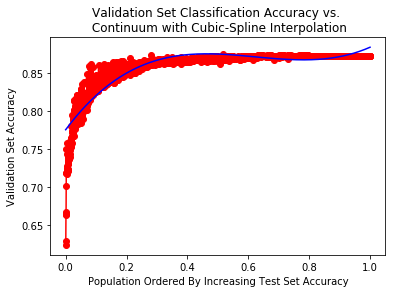

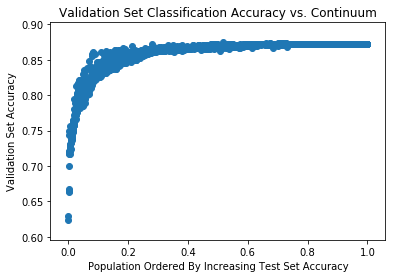

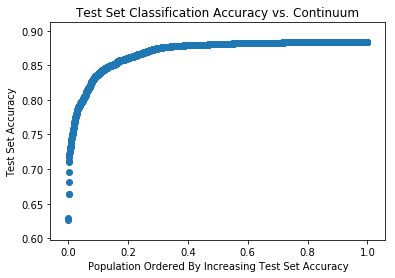

In [25]:
import matplotlib.pyplot as plt

'''
	Now, we plot the test and validation classification accuracy to see how these numbers change as we move from our worst feature subsets to the 
	best feature subsets found by the genetic algorithm.
'''

# Calculate best fit line for validation classification accuracy (non-linear)
tck = interpolate.splrep(percentileList, validationAccuracyList, s=5.0)
ynew = interpolate.splev(percentileList, tck)

e = plt.figure(1)
plt.plot(percentileList, validationAccuracyList, marker='o', color='r')
plt.plot(percentileList, ynew, color='b')
plt.title('Validation Set Classification Accuracy vs. \n Continuum with Cubic-Spline Interpolation')
plt.xlabel('Population Ordered By Increasing Test Set Accuracy')
plt.ylabel('Validation Set Accuracy')
# e.show()

f = plt.figure(2)
plt.scatter(percentileList, validationAccuracyList)
plt.title('Validation Set Classification Accuracy vs. Continuum')
plt.xlabel('Population Ordered By Increasing Test Set Accuracy')
plt.ylabel('Validation Set Accuracy')
# f.show()

g = plt.figure(3)
plt.scatter(percentileList, testAccuracyList)
plt.title('Test Set Classification Accuracy vs. Continuum')
plt.xlabel('Population Ordered By Increasing Test Set Accuracy')
plt.ylabel('Test Set Accuracy')
# g.show()

# input()

In [20]:
import pandas as pd

df_testAccuracyList = pd.DataFrame(testAccuracyList, columns=["testAccuracy"])
df_testAccuracyList.to_csv('testAccuracyList.csv', index=False)

df_validationAccuracyList = pd.DataFrame(validationAccuracyList, columns=["validationAccuracy"])
df_validationAccuracyList.to_csv('validationAccuracyList.csv', index=False)

individualList = np.asarray(individualList)
df_individualList = pd.DataFrame(individualList)
df_individualList.to_csv('individualList.csv', index=False)
df_individualList['sum'] = df_individualList.sum(axis=1)

df_percentileList = pd.DataFrame(percentileList, columns=["percentile"])
df_percentileList.to_csv('percentileList.csv', index=False)


In [21]:
np.unique(df_individualList['sum'])

array([29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
       46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56])

In [22]:
# df_individualList.where(df_individualList['sum']==27)
from collections import defaultdict
index_where = defaultdict(list)
# [index_where for index in range(len(df_individualList)) if df_individualList['sum'][:,index]==27]

In [23]:
for i in range (len(df_individualList)):
    index_where[(df_individualList['sum'][i])].append(i)

In [39]:
from collections import OrderedDict

valAccList = defaultdict(list)
for item in index_where:
#     print(item)
    valAcc = np.max(df_validationAccuracyList.iloc[index_where[item]])[0]
    valAccList[item].append(valAcc)
    
valAccList = OrderedDict(sorted(valAccList.items()))

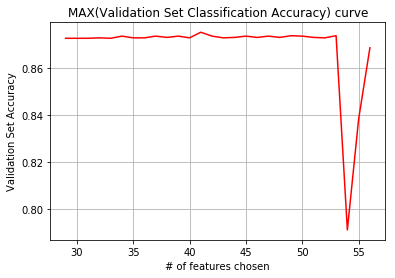

In [45]:
g = plt.figure(4)
plt.plot(list(valAccList.keys())[1:], list(valAccList.values())[1:], color='r')
plt.title('MAX(Validation Set Classification Accuracy) curve')
plt.xlabel('# of features chosen')
plt.ylabel('Validation Set Accuracy')
plt.grid()

In [43]:
from collections import OrderedDict

valAccList_mean = defaultdict(list)
for item in index_where:
#     print(item)
    valAcc_mean = np.mean(df_validationAccuracyList.iloc[index_where[item]])[0]
    valAccList_mean[item].append(valAcc_mean)
    
valAccList_mean = OrderedDict(sorted(valAccList_mean.items()))

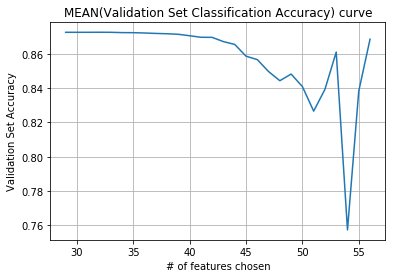

In [48]:
g = plt.figure(5)
plt.plot(list(valAccList_mean.keys())[1:], list(valAccList_mean.values())[1:])
plt.title('MEAN(Validation Set Classification Accuracy) curve')
plt.xlabel('# of features chosen')
plt.ylabel('Validation Set Accuracy')
plt.grid()